# Zebrafish pigmentation

This tutorial uses data from [Saunders, et al (2019)](https://elifesciences.org/articles/45181). Special thanks also go to [Lauren](https://twitter.com/LSaund11) for the tutorial improvement. 

In this [study](https://elifesciences.org/articles/45181), the authors profiled thousands of neural crest-derived cells from trunks of post-embryonic zebrafish. These cell classes include pigment cells, multipotent pigment cell progenitors, peripheral neurons, Schwann cells, chromaffin cells and others. These cells were collected during an active period of post-embryonic development, which has many similarities to fetal and neonatal development in mammals, when many of these cell types are migrating and differentiating as the animal transitions into its adult form. This study also explores the role of thyroid hormone (TH), a common endocrine factor, on the development of these different cell types. 

Such developmental and other dynamical processes are especially suitable for dynamo analysis as dynamo is designed to accurately estimate direction and magnitude of expression dynamics (`RNA velocity`), predict the entire lineage trajectory of any intial cell state (`vector field`), characterize the structure (`vector field topology`) of full gene expression space, as well as fate commitment potential (`single cell potential`). 

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [1]:
import dynamo as dyn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from dynamo.configuration import DKM
import warnings
warnings.filterwarnings('ignore')


this is like R's sessionInfo() which helps you to debug version related bugs if any. 

## Load data

In [2]:
adata = dyn.sample_data.zebrafish()
monocle_adata = dyn.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> Downloading data to ./data/zebrafish.h5ad


In [3]:
print(adata)


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'


Text(0.5, 1.0, 'preprocessor adata.X')

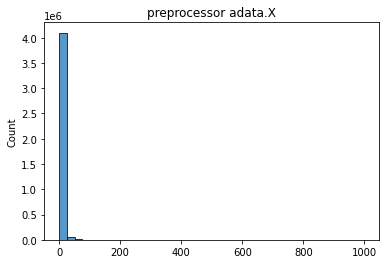

In [4]:
sns.histplot(adata.X.data, bins=40, legend=False).set_title(
    "preprocessor adata.X")


In [5]:
print(adata.X.min(), adata.X.max(), adata.X.mean())
adata.layers["spliced"] = adata.layers["spliced"].toarray()
temp = adata.layers["spliced"][~np.isnan(adata.layers["spliced"])]
print("unspliced data ")
print(temp.min(), temp.max(), temp.mean(),  temp.std())
adata.layers["unspliced"] = adata.layers["unspliced"].toarray()
temp = adata.layers["unspliced"][~np.isnan(adata.layers["unspliced"])]
print(temp.min(), temp.max(), temp.mean(), temp.std())


0.0 998.0 0.17253423
unspliced data 
0 998 0.17253422253422254 1.9774504673842888
0 2952 0.13544723741827522 6.526400485300376


## Apply pearson residual normalization on different layers according `select_genes_key`. We may use other select_genes function combined with pearson residual normalization.

In [6]:
# adata = dyn.sample_data.zebrafish()
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
monocle_filter_genes_by_outliers_kwargs = Preprocessor.get_monocle_filter_genes_outliers_kwargs(
    adata)
preprocessor = Preprocessor(
    filter_genes_by_outliers_kwargs=monocle_filter_genes_by_outliers_kwargs)
preprocessor.config_monocle_recipe(adata)
preprocessor.preprocess_adata(adata)


|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----> Running preprocessing pipeline...
|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----------> <insert> tkey=None to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type=None to uns['pp'] in AnnData Object.
|-----> making adata observation index unique...
|-----> applying collapse species adata...
|-----> applying convert_gene_name function...
|-----> filtering outlier cells...
|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> keep filtered genes
|-----> filtering outlier genes...
|-----> extra kwargs:{'filter_bool': None, 'layer': 'all', 'min_cell_s': 41.81, 'min_cell_u': 20.905, 'min_cell_p': 20.905, 'min_avg_exp_s': 0, 'min_avg_exp_u': 0, 'min_avg_exp_p': 0, 'max_avg_exp'

In [7]:
dyn.preprocessing.recipe_monocle(monocle_adata)


|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

## Gene set difference between Monocle and Preprocessor adata results 

In [8]:
preprocess_genes = adata.var_names[adata.var["pass_basic_filter"]]
monocle_genes = monocle_adata.var_names[adata.var["pass_basic_filter"]]
assert not set(monocle_genes).difference(set(preprocess_genes))
assert not set(preprocess_genes).difference(set(monocle_genes))


In [9]:
preprocess_genes = adata.var_names[adata.var["use_for_pca"]]
monocle_genes = monocle_adata.var_names[adata.var["use_for_pca"]]
assert not set(monocle_genes).difference(set(preprocess_genes))
assert not set(preprocess_genes).difference(set(monocle_genes))


In [10]:
dyn.tl.reduceDimension(adata,basis="pca")
dyn.tl.reduceDimension(monocle_adata,basis="pca")

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [40.6606s]
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [14.9922s]


## Quantitative difference between Monocle and Preprocessor adata results 

In [11]:
print(np.sum(np.abs(adata.X - monocle_adata.X)))
print(
    np.sum(np.abs(adata.layers["X_spliced"] - monocle_adata.layers["X_spliced"])))
print(np.sum(
    np.abs(adata.layers["X_unspliced"] - monocle_adata.layers["X_unspliced"])))
print(np.sum(np.abs(adata.obsm["X_pca"] - monocle_adata.obsm["X_pca"])))


0.0
1.7062240509346793e-10
1.887602851802228e-10
0.0


In [12]:
print(np.sum(np.abs(adata.X - monocle_adata.X)))
# underlying data order not ensured
print(np.sum(np.abs(adata.X.data - monocle_adata.X.data)))
print(np.sum(np.abs(adata.X.toarray() - monocle_adata.X.toarray())))


0.0
0.0
0.0


In [13]:
len(monocle_adata.X.data)


4166246

In [14]:
indices = adata.X.nonzero()
np.array(adata.X[indices]).flatten()


array([3.4070625, 3.4070625, 3.4070625, ..., 2.2493198, 2.2047036,
       2.6846313], dtype=float32)

In [15]:
np.array(monocle_adata.X[indices]).flatten()


array([3.4070625, 3.4070625, 3.4070625, ..., 2.2493198, 2.2047036,
       2.6846313], dtype=float32)

## X, X_pca, X_spliced, X_unspliced plot comparison

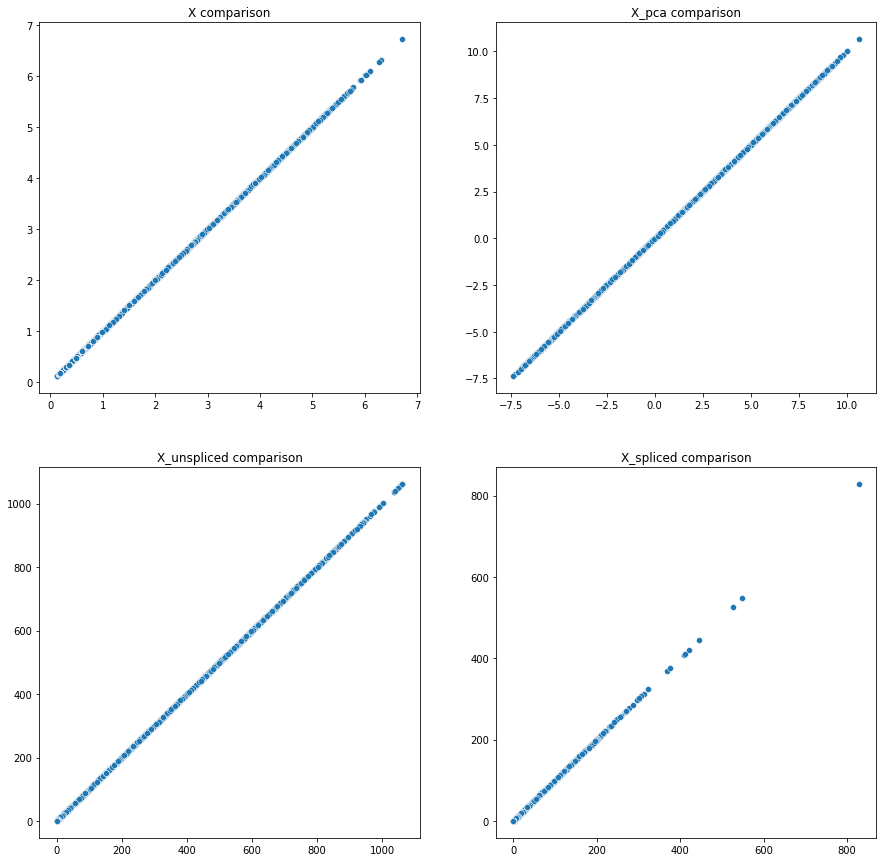

In [16]:
import seaborn as sns
import scipy.sparse


def get_nonzero_np_arr(X: scipy.sparse.csr_matrix):
    return np.array(X[X.nonzero()]).flatten()

def plot_scatter_sparse(m1: scipy.sparse.csr_matrix, m2: scipy.sparse.csr_matrix, title="", **kwargs):
    sns.scatterplot(np.array(m1[m1.nonzero()]).flatten(), np.array(m2[m1.nonzero()]).flatten(), **kwargs).set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
plot_scatter_sparse(adata.X, monocle_adata.X, ax=axes[0][0], title="X comparison")
plot_scatter_sparse(adata.obsm["X_pca"], monocle_adata.obsm["X_pca"], ax=axes[0][1], title="X_pca comparison")
plot_scatter_sparse(adata.layers["X_unspliced"], monocle_adata.layers["X_unspliced"], ax=axes[1][0], title="X_unspliced comparison")
plot_scatter_sparse(adata.layers["X_spliced"], monocle_adata.layers["X_spliced"], ax=axes[1][1], title="X_spliced comparison")

plt.show()


## Size factor comparison

In [17]:
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size'
    var: 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'gene_highly_variable'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'neighbors', 'umap_fit'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

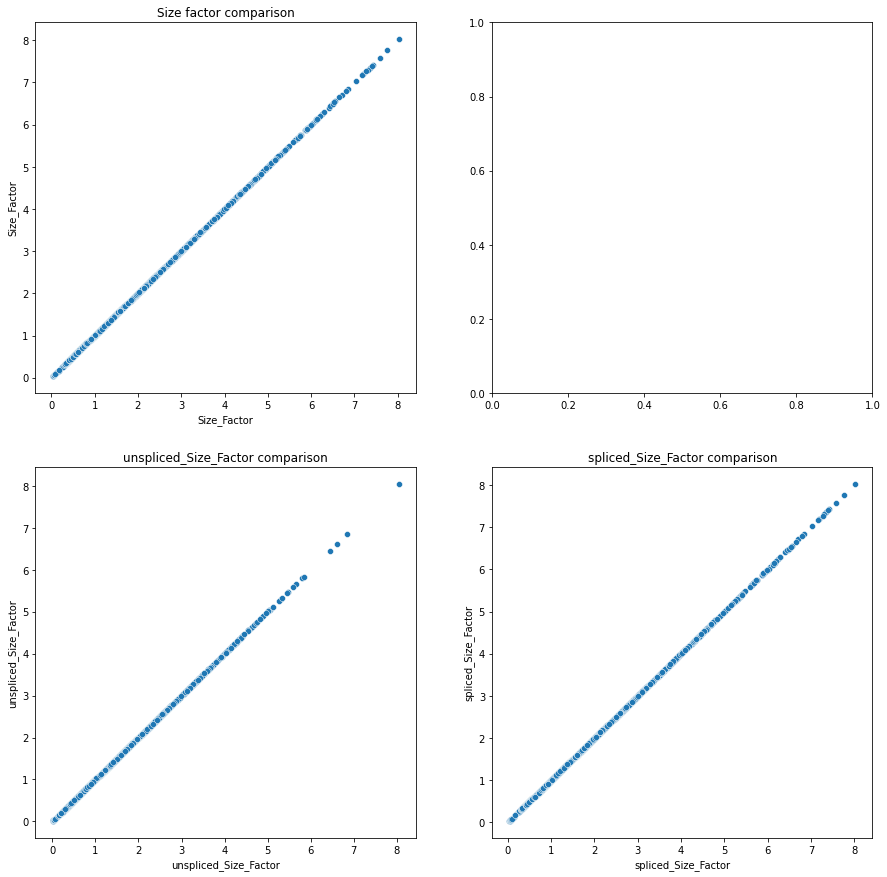

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.scatterplot(adata.obs["Size_Factor"], monocle_adata.obs["Size_Factor"], ax=axes[0][0]).set_title("Size factor comparison")
sns.scatterplot(adata.obs["unspliced_Size_Factor"], monocle_adata.obs["unspliced_Size_Factor"], ax=axes[1][0]).set_title("unspliced_Size_Factor comparison")
sns.scatterplot(adata.obs["spliced_Size_Factor"], monocle_adata.obs["spliced_Size_Factor"], ax=axes[1][1]).set_title("spliced_Size_Factor comparison")
plt.show()

## Histogram showing distributions of X_pca and X

Text(0.5, 1.0, 'monocle X_pca')

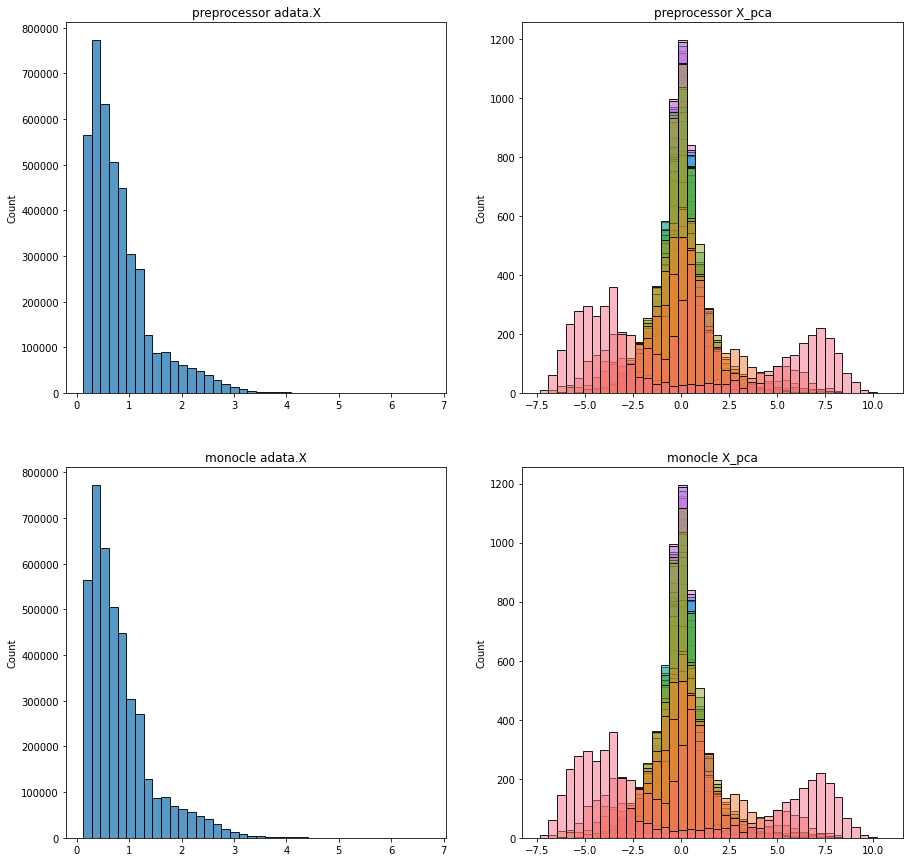

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(adata.X.data, bins=40, legend=False, ax=axes[0][0]).set_title("preprocessor adata.X")
sns.histplot(adata.obsm["X_pca"], bins=40, legend=False, ax=axes[0][1]).set_title("preprocessor X_pca")
sns.histplot(monocle_adata.X.data, bins=40, legend=False, ax=axes[1][0]).set_title("monocle adata.X")
sns.histplot(monocle_adata.obsm["X_pca"], bins=40, legend=False, ax=axes[1][1]).set_title("monocle X_pca")

# _, axes = plt.subplots(2, 2, figsize=(15, 15))
# sns.histplot(adata.layers["X_unspliced"], bins=40, legend=False, ax=axes[0][0]).set_title("preprocessor X_unspliced")
# sns.histplot(monocle_adata.layers["X_unspliced"], bins=40, legend=False, ax=axes[0][1]).set_title("preprocessor X_spliced")

# sns.histplot(adata.layers["X_spliced"], bins=40, legend=False, ax=axes[1][0]).set_title("preprocessor X_unspliced")
# sns.histplot(monocle_adata.layers["X_spliced"], bins=40, legend=False, ax=axes[1][1]).set_title("preprocessor X_spliced")


<Figure size 1000x1000 with 0 Axes>

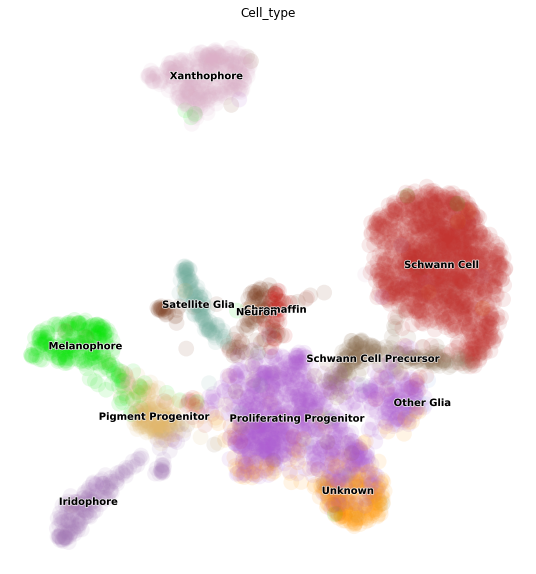

<Figure size 1000x1000 with 0 Axes>

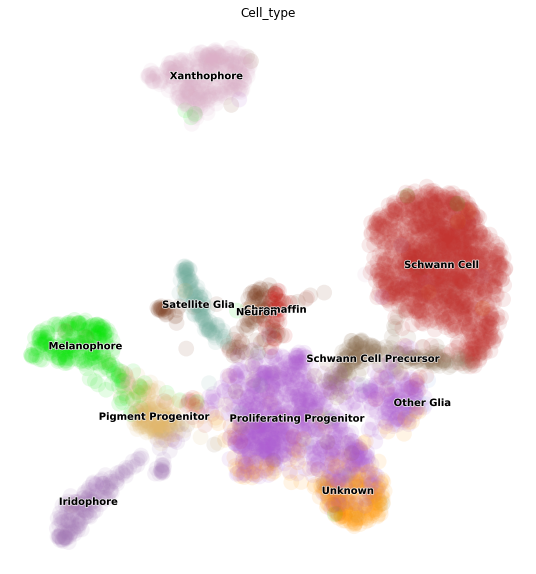

In [20]:
dyn.pl.umap(adata, color="Cell_type", figsize=(10, 10))  # , ax=axes[0])
dyn.pl.umap(monocle_adata, color="Cell_type",
            figsize=(10, 10))  # , ax=axes[1])


In [21]:
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size'
    var: 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'gene_highly_variable'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'neighbors', 'umap_fit', 'Cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

In [22]:
dyn.tl.dynamics(adata, model='stochastic', cores=3)
dyn.tl.dynamics(monocle_adata, model='stochastic', cores=3)


|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [19.4031s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [11.1940s]


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'neighbors', 'umap_fit', 'Cell_type_colors', 'dynamics'
    obsm: 'X_pca', 'X', 'X_umap'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'veloc

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.4066s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] i

<Figure size 600x400 with 0 Axes>

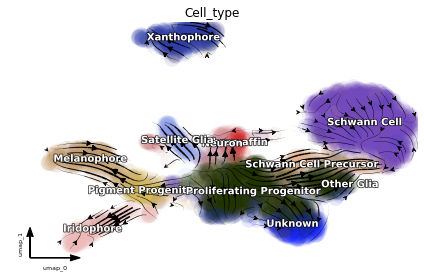

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.4183s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] i

<Figure size 600x400 with 0 Axes>

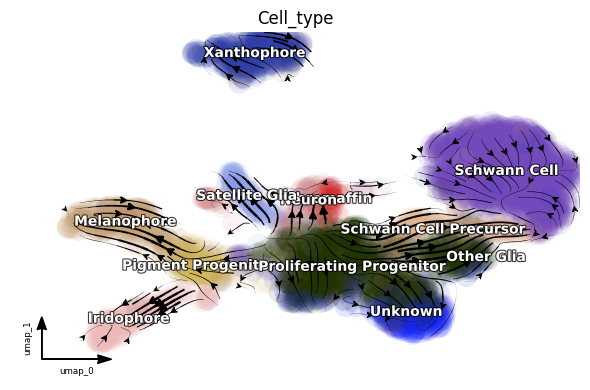

In [23]:
dyn.pl.streamline_plot(adata, color=[
                       'Cell_type'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.pl.streamline_plot(monocle_adata, color=[
                       'Cell_type'], basis='umap', show_legend='on data', show_arrowed_spines=True)


In [24]:
monocle_adata.shape


(4181, 16940)

## plot preprocessor's velocity on recipe_monocle's UMAP

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis monocle-umap. dimension reduction monocle-umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.4070s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [projecting velocity vector to low dimensional embedding]

Using existing pearson_transition_matrix found in .obsp.


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.9182s]


<Figure size 600x400 with 0 Axes>

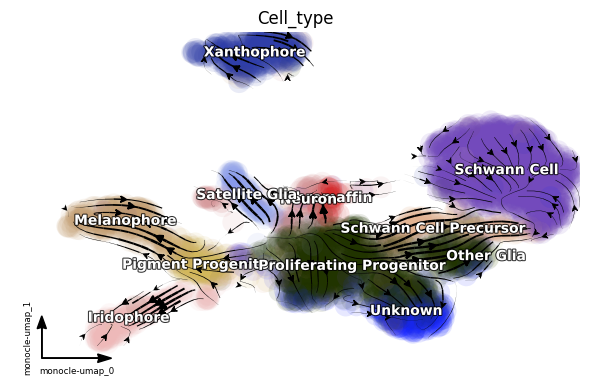

In [25]:
adata.obsm["X_monocle-umap"] = monocle_adata.obsm["X_umap"]
dyn.pl.streamline_plot(adata, color=[
                       'Cell_type'], basis='monocle-umap', show_legend='on data', show_arrowed_spines=True)


## plot preprocessor's UMAP with recipe_monocle's velocity

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis preprocessor-umap. dimension reduction preprocessor-umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.5017s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [projecting velocity vector to low dimensional 

Using existing pearson_transition_matrix found in .obsp.


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.9270s]


<Figure size 600x400 with 0 Axes>

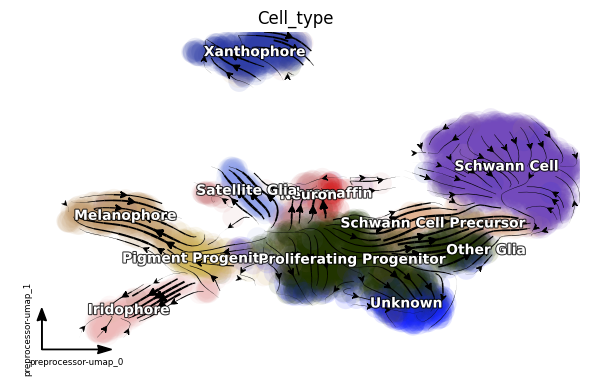

In [26]:
monocle_adata.obsm["X_preprocessor-umap"] = adata.obsm["X_umap"]
dyn.pl.streamline_plot(monocle_adata, color=[
                       'Cell_type'], basis='preprocessor-umap', show_legend='on data', show_arrowed_spines=True)


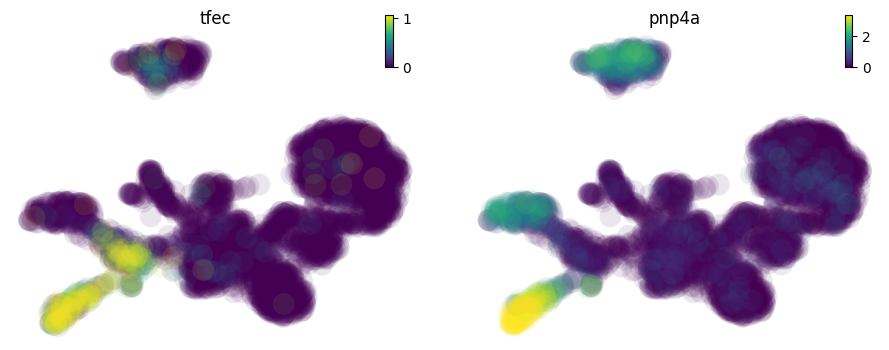

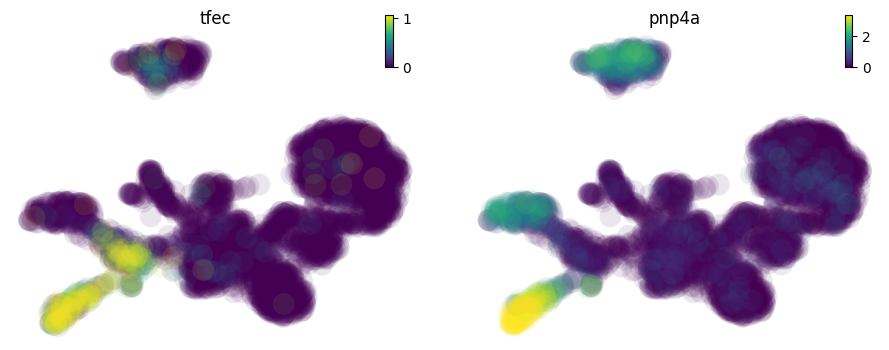

In [27]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'])
dyn.pl.umap(monocle_adata, color=['tfec', 'pnp4a'])

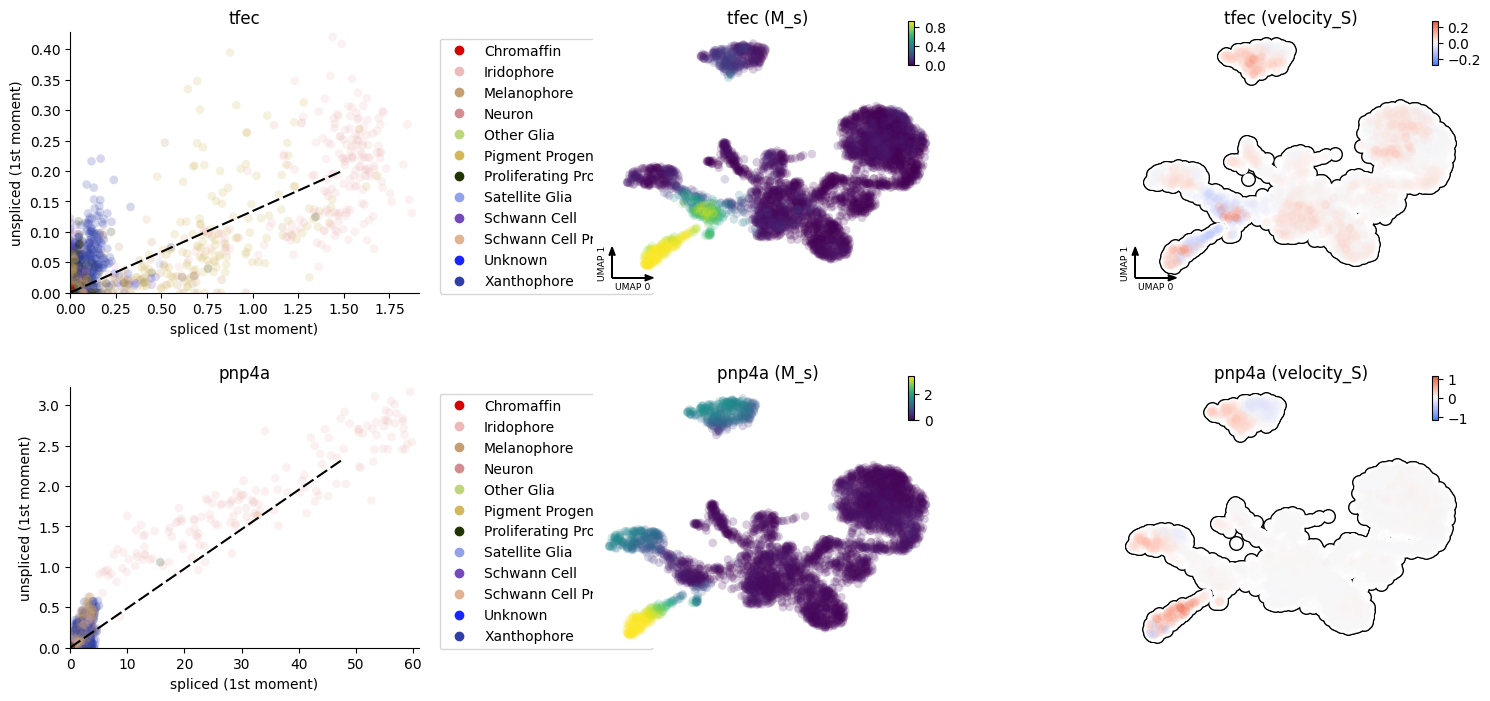

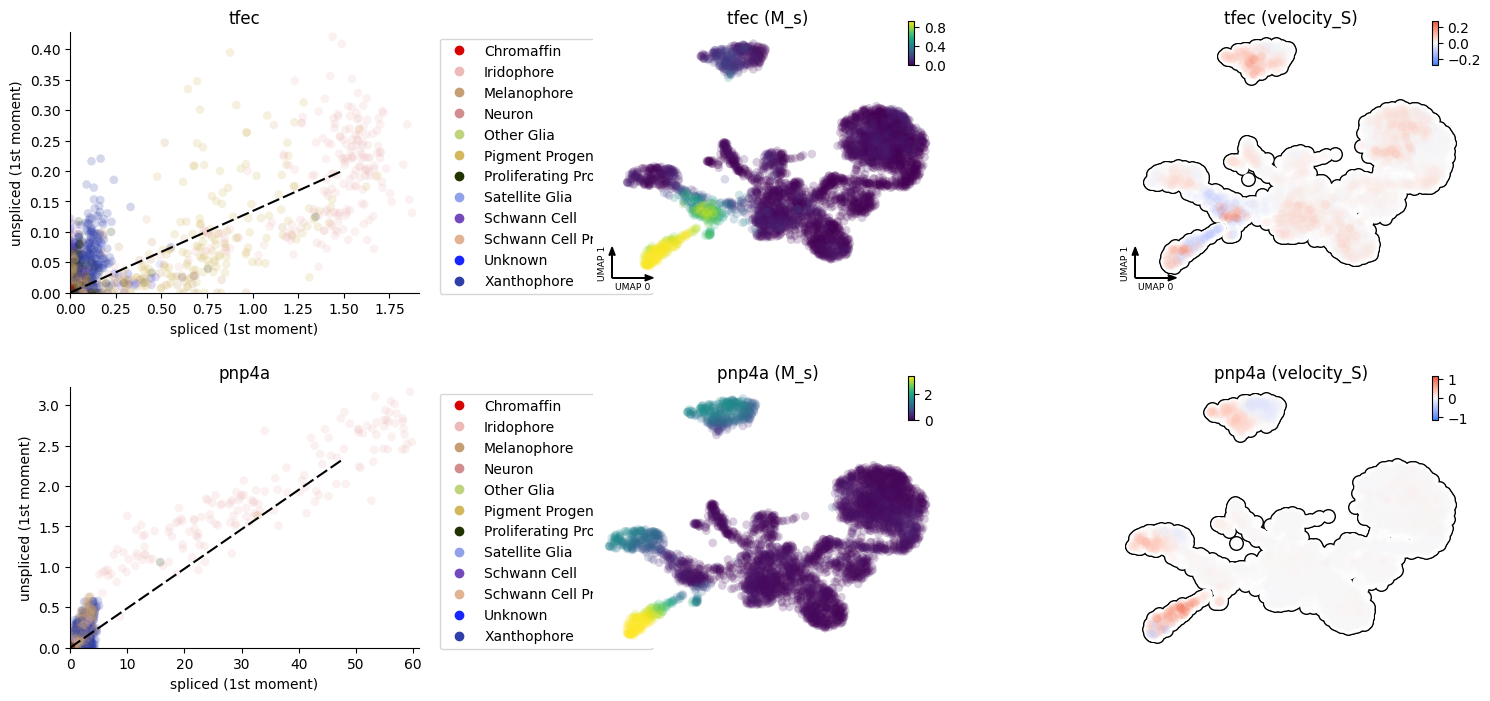

In [28]:
dyn.pl.phase_portraits(adata, genes=['tfec', 'pnp4a'],  figsize=(6, 4), color='Cell_type')
dyn.pl.phase_portraits(monocle_adata, genes=['tfec', 'pnp4a'],  figsize=(6, 4), color='Cell_type')

In [29]:
adata.layers["spliced"]


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   1, ...,   0,   0,   0],
       ...,
       [121,  44,  81, ...,   0,   0,   0],
       [139,  63,  82, ...,   0,   0,   0],
       [ 66,  39,  41, ...,   0,   0,   0]], dtype=int64)

In [30]:
print(adata.X.min(), adata.X.max(), adata.X.mean(),  temp.std())
temp = adata.layers["spliced"][~np.isnan(adata.layers["spliced"])]
print(temp.min(), temp.max(), temp.mean(),  temp.std())
temp = adata.layers["unspliced"][~np.isnan(adata.layers["unspliced"])]
print(temp.min(), temp.max(), temp.mean(), temp.std())


0.0 6.720943 0.048067838 6.526400485300376
0 998 0.17253422253422254 1.9774504673842888
0 2952 0.13544723741827522 6.526400485300376


In [31]:
adata.uns["pp"]


{'tkey': None,
 'has_splicing': True,
 'has_labeling': False,
 'has_protein': False,
 'splicing_labeling': False,
 'experiment_type': 'conventional',
 'experiment_layers': ['X', 'spliced', 'unspliced'],
 'experiment_total_layers': None,
 'norm_method': None}